In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime

In [3]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
#path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/REPPU/200/pbig5min.dat' #Ubuntu
path = r'/home/sachin/Documents/NIPR/Research/Data/REPPU/pbig5min.dat' #Server

#read the REPPU data
with open (path) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

reppu_data = reppu_data.reshape(-1,30,80)
reppu_data.shape

(45792, 30, 80)

In [6]:
#Read MHD dates and expand-out the date ranges
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
    for start, end in zip(mhd_data['start'], mhd_data['end'])])

In [7]:
time_res = 5

if time_res == 1:
    time_step = 1440
else :
    time_step = 288

In [8]:
data_reshaped = reppu_data.reshape(len(expanded_dt), time_step, 30, 80) 

# Define coordinates
time = np.arange(time_step)
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*time_res))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({'potential': (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add potential and units
ds['potential'].attrs['units'] = 'kV'
ds['potential'] = ds['potential'] * 1e-3 # Convert to kV
ds

<xarray.Dataset> Size: 440MB
Dimensions:    (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt         (dt) datetime64[ns] 366kB 2021-05-10 ... 2022-08-19T23:55:00
  * lat        (lat) float64 240B 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon        (lon) float64 640B 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    potential  (dt, lat, lon) float32 440MB 0.6909 0.507 ... -22.67 -22.71

In [9]:
#omni_df = pd.read_csv('omni_mhd_5min.csv')
omni_df = pd.read_csv('omni_add-feats_mhd_5min.csv')
#omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_5min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.ffill().bfill()
omni_df = omni_df.dropna() #drop any remaining NaNs
omni_df

omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='outer')

#select date range
reppu_omni_ds = reppu_omni_ds.sortby('dt')
reppu_omni_ds

#reppu_omni_ds = reppu_omni_ds.drop_vars(['E', 'doy','BSN_x','SYM_H','F10.7','Kp','Mach_num','Pressure','T'])#
#reppu_omni_ds = reppu_omni_ds.drop_vars(['flow_speed','proton_density'])

if time_res == 1:
    #interpolate the missing values in BY_GSE
    reppu_omni_ds['BY_GSE'] = reppu_omni_ds['BY_GSE'].interpolate_na(dim='dt')
    reppu_omni_ds['BZ_GSE'] = reppu_omni_ds['BZ_GSE'].interpolate_na(dim='dt')
    reppu_omni_ds['flow_speed'] = reppu_omni_ds['flow_speed'].interpolate_na(dim='dt')
    reppu_omni_ds['proton_density'] = reppu_omni_ds['proton_density'].interpolate_na(dim='dt')
    reppu_omni_ds['tilt_angle'] = reppu_omni_ds['tilt_angle'].interpolate_na(dim='dt')

    #drop nan values
    reppu_omni_ds = reppu_omni_ds.dropna('dt')
    reppu_omni_ds
else:
    pass

reppu_omni_ds

<xarray.Dataset> Size: 445MB
Dimensions:         (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 366kB 2021-05-10 ... 2022-08-19T23:55:00
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 1.6 6.106 10.61 ... 348.6 353.1 357.6
Data variables: (12/15)
    potential       (dt, lat, lon) float32 440MB 0.6909 0.507 ... -22.67 -22.71
    BY_GSE          (dt) float64 366kB 4.72 4.35 4.61 4.65 ... -2.49 -2.04 -1.92
    BZ_GSE          (dt) float64 366kB 6.24 6.55 6.56 6.89 ... -4.47 -4.64 -4.5
    flow_speed      (dt) float64 366kB 344.0 344.0 345.0 ... 655.0 653.0 658.0
    proton_density  (dt) float64 366kB 12.11 11.44 12.65 ... 6.22 5.59 5.34
    T               (dt) float64 366kB 2.457e+04 1.984e+04 ... 2.879e+05
    ...              ...
    BSN_x           (dt) float64 366kB 12.82 12.85 12.72 ... 10.74 10.92 10.91
    SYM_H           (dt) float64 366kB 17.0 17.0 17.0 18.0 ... -39.0 -41.0 -41.0
    F10.7           (dt) float64 366kB 78.0 78.0 78.0 78.0 ... 107.0 107.0 107.0
    Kp              (dt) float64 366kB 1.0 1.0 1.0 1.0 1.0 ... 4.0 4.0 4.0 4.0
    doy             (dt) float64 366kB 130.0 130.0 130.0 ... 231.0 231.0 231.0
    tilt_angle      (dt) float64 366kB 0.253 0.2497 0.2465 ... 0.1769 0.1735

In [10]:
features = ['potential', 'BY_GSE', 'BZ_GSE', 'tilt_angle','flow_speed','proton_density']
reppu_omni_ds = reppu_omni_ds[features]
reppu_omni_ds

<xarray.Dataset> Size: 442MB
Dimensions:         (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 366kB 2021-05-10 ... 2022-08-19T23:55:00
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 1.6 6.106 10.61 ... 348.6 353.1 357.6
Data variables:
    potential       (dt, lat, lon) float32 440MB 0.6909 0.507 ... -22.67 -22.71
    BY_GSE          (dt) float64 366kB 4.72 4.35 4.61 4.65 ... -2.49 -2.04 -1.92
    BZ_GSE          (dt) float64 366kB 6.24 6.55 6.56 6.89 ... -4.47 -4.64 -4.5
    tilt_angle      (dt) float64 366kB 0.253 0.2497 0.2465 ... 0.1769 0.1735
    flow_speed      (dt) float64 366kB 344.0 344.0 345.0 ... 655.0 653.0 658.0
    proton_density  (dt) float64 366kB 12.11 11.44 12.65 ... 6.22 5.59 5.34

In [11]:
X_train_a = reppu_omni_ds.sel(dt=slice("2021-05-10","2022-06-30")) #123 days
X_train_b = reppu_omni_ds.sel(dt=slice("2022-08-15","2022-08-19")) #5 days
X_train_ds = xr.concat([X_train_a, X_train_b], dim='dt') #128 days ~80% of the data
X_val_ds = reppu_omni_ds.sel(dt=slice("2022-07-16","2022-07-31")) #15 days ~10% of the data
X_test_ds = reppu_omni_ds.sel(dt=slice("2022-07-01","2022-07-15")) #15 days ~10% of the data
X_test_unscaled_ds = X_test_ds.copy() #keep a copy of the unscaled test data for later use

In [12]:
X_train_ds

<xarray.Dataset> Size: 356MB
Dimensions:         (dt: 36864, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 295kB 2021-05-10 ... 2022-08-19T23:55:00
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 1.6 6.106 10.61 ... 348.6 353.1 357.6
Data variables:
    potential       (dt, lat, lon) float32 354MB 0.6909 0.507 ... -22.67 -22.71
    BY_GSE          (dt) float64 295kB 4.72 4.35 4.61 4.65 ... -2.49 -2.04 -1.92
    BZ_GSE          (dt) float64 295kB 6.24 6.55 6.56 6.89 ... -4.47 -4.64 -4.5
    tilt_angle      (dt) float64 295kB 0.253 0.2497 0.2465 ... 0.1769 0.1735
    flow_speed      (dt) float64 295kB 344.0 344.0 345.0 ... 655.0 653.0 658.0
    proton_density  (dt) float64 295kB 12.11 11.44 12.65 ... 6.22 5.59 5.34

In [13]:
# List of variables to be scaled (excluding 'potential')
variables_to_scale = [var for var in X_train_ds.data_vars if var != 'potential']

# Fit the scaler on training data
scaler = MinMaxScaler()

for var in variables_to_scale:
    # Reshape the variable to (-1, 1) to fit the scaler
    X_train_values = X_train_ds[var].values.reshape(-1,1)
    X_val_values = X_val_ds[var].values.reshape(-1, 1)
    X_test_values = X_test_ds[var].values.reshape(-1, 1)

    # Fit and transform on training data, then transform on test data
    scaled_train_values = scaler.fit_transform(X_train_values).reshape(X_train_ds[var].shape)
    scaled_val_values = scaler.transform(X_val_values).reshape(X_val_ds[var].shape)
    scaled_test_values = scaler.transform(X_test_values).reshape(X_test_ds[var].shape)
    
    # Update the xarray dataset with the scaled values
    X_train_ds[var] = (X_train_ds[var].dims, scaled_train_values)
    X_val_ds[var] = (X_val_ds[var].dims, scaled_val_values)
    X_test_ds[var] = (X_test_ds[var].dims, scaled_test_values)

In [14]:
def single_feat_ds(ds, lookback, var):
    ds_shifted = ds.copy()
    
    for i in range(1, lookback + 1):
        ds_shifted[f'BY_GSE(t-{i})'] = ds['BY_GSE'].shift(dt=i)
        ds_shifted[f'BZ_GSE(t-{i})'] = ds['BZ_GSE'].shift(dt=i)
        #ds_shifted[f'Pressure(t-{i})'] = ds['Pressure'].shift(dt=i)
        ds_shifted[f'flow_speed(t-{i})'] = ds['flow_speed'].shift(dt=i)
        ds_shifted[f'proton_density(t-{i})'] = ds['proton_density'].shift(dt=i)
        #ds_shifted[f'tilt_angle(t-{i})'] = ds['tilt_angle'].shift(dt=i)
        #ds_shifted[f'T(t-{i})'] = ds['T'].shift(dt=i)
        #ds_shifted[f'E(t-{i})'] = ds['E'].shift(dt=i)
        #ds_shifted[f'doy(t-{i})'] = ds['doy'].shift(dt=i)
        #ds_shifted[f'BSN_x(t-{i})'] = ds['BSN_x'].shift(dt=i)
        #ds_shifted[f'SYM_H(t-{i})'] = ds['SYM_H'].shift(dt=i)
        #ds_shifted[f'F10.7(t-{i})'] = ds['F10.7'].shift(dt=i)
        #ds_shifted[f'Kp(t-{i})'] = ds['Kp'].shift(dt=i)
        #ds_shifted[f'Mach_num(t-{i})'] = ds['Mach_num'].shift(dt=i)
        
    ds_shifted = ds_shifted.dropna(dim='dt')
    
    return ds_shifted

#features = ['BY_GSE', 'BZ_GSE', 'tilt_angle', 'flow_speed', 'proton_density']
lookback = 3

X_train_ds_lookback = single_feat_ds(X_train_ds, lookback, features)
X_val_ds_lookback = single_feat_ds(X_val_ds, lookback, features)
X_test_ds_lookback = single_feat_ds(X_test_ds, lookback, features)

In [15]:
mins = str(lookback * 5)

reset_training_dates = [
    #{"start": "2021/05/10 00:00:00", "end": "2021/05/14 23:59:59", "total_days": 5},
    {"start": "2021/05/31 00:00:00"},
    {"start": "2021/07/26 00:00:00"},
    {"start": "2021/09/09 00:00:00"},
    {"start": "2021/10/11 00:00:00"},
    {"start": "2021/11/01 00:00:00"},
    {"start": "2021/11/25 00:00:00"},
    {"start": "2021/12/01 00:00:00"},
    {"start": "2022/01/30 00:00:00"},
    {"start": "2022/03/11 00:00:00"},
    {"start": "2022/03/28 00:00:00"},
    {"start": "2022/06/10 00:00:00"},
    #{"start": "2022/07/01 00:00:00", "end": "2022/07/31 23:59:59", "total_days": 31}, #test data
    #{"start": "2022/07/16 00:00:00"},
    {"start": "2022/08/15 00:00:00"}
]


In [16]:
mins = str(lookback * 5)

reset_test_dates = [
    {"start": f"2022/07/16 00:{mins}:00"} #test data
]

In [17]:
def remove_reset_date(ds, reset_dates, remove_range, features):
    ds = ds.copy()

    date = ds['dt'].values
    date = pd.to_datetime(date).to_pydatetime()

    reset_indices = [np.where(date == datetime.datetime.strptime(d["start"], "%Y/%m/%d %H:%M:%S"))[0][0] for d in reset_dates] #get the indices of the reset dates
    reset_indices = np.array([list(range(i, min(i+remove_range+1, len(date)))) for i in reset_indices]).flatten() #get the indices of the reset dates and the next n days

    for feature in features:
        ds[feature].values[reset_indices] = np.nan

    ds = ds.dropna(dim='dt')
    
    return ds

X_train_ds_reset = remove_reset_date(X_train_ds_lookback, reset_training_dates, lookback, features)
#X_test_ds_reset = remove_reset_date(X_test_ds_lookback, reset_test_dates, lookback, features)

In [18]:
X_train_ds_reset

<xarray.Dataset> Size: 359MB
Dimensions:              (dt: 36813, lat: 30, lon: 80)
Coordinates:
  * dt                   (dt) datetime64[ns] 295kB 2021-05-10T00:15:00 ... 20...
  * lat                  (lat) float64 240B 53.1 54.36 55.62 ... 88.44 89.7
  * lon                  (lon) float64 640B 1.6 6.106 10.61 ... 353.1 357.6
Data variables: (12/18)
    potential            (dt, lat, lon) float32 353MB 1.923 1.671 ... -22.71
    BY_GSE               (dt) float64 295kB 0.6046 0.6094 ... 0.4641 0.4666
    BZ_GSE               (dt) float64 295kB 0.6284 0.6378 ... 0.3898 0.3927
    tilt_angle           (dt) float64 295kB 0.7131 0.7103 0.7075 ... 0.655 0.652
    flow_speed           (dt) float64 295kB 0.1137 0.1155 ... 0.6715 0.6805
    proton_density       (dt) float64 295kB 0.1988 0.1962 ... 0.08256 0.07843
    ...                   ...
    flow_speed(t-2)      (dt) float64 295kB 0.1137 0.1155 ... 0.6751 0.6751
    proton_density(t-2)  (dt) float64 295kB 0.1792 0.1991 ... 0.09297 0.09297
    BY_GSE(t-3)          (dt) float64 295kB 0.606 0.5983 ... 0.4357 0.4546
    BZ_GSE(t-3)          (dt) float64 295kB 0.615 0.6214 ... 0.3949 0.3933
    flow_speed(t-3)      (dt) float64 295kB 0.1137 0.1137 ... 0.6643 0.6751
    proton_density(t-3)  (dt) float64 295kB 0.1902 0.1792 ... 0.1044 0.09297

In [19]:
def nan_count(ds, var):
    #count number of NaNs in a data variable
    con_data = ds[var].values
    nan_count = np.count_nonzero(np.isnan(con_data))
    nan_ratio = nan_count / con_data.size
    not_nan = con_data.size - nan_count
    return not_nan, np.round(nan_ratio, 2)

nan_count(X_train_ds_reset, 'potential')

(88351200, 0.0)

In [20]:
X_train = X_train_ds_reset.drop_vars('potential').to_array().values.T
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
y_train = X_train_ds_reset['potential'].values
y_train = y_train.reshape(-1, 30*80)

X_val = X_val_ds_lookback.drop_vars('potential').to_array().values.T
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)
y_val = X_val_ds_lookback['potential'].values
y_val = y_val.reshape(-1, 30*80)

X_test = X_test_ds_lookback.drop_vars('potential').to_array().values.T
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)
y_test = X_test_ds_lookback['potential'].values
y_test = y_test.reshape(-1, 30*80)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((36813, 17, 1),
 (36813, 2400),
 (4605, 17, 1),
 (4605, 2400),
 (4317, 17, 1),
 (4317, 2400))

In [21]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

X_train_tensor.shape, y_train_tensor.shape, X_val_tensor.shape, y_val_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([36813, 17, 1]),
 torch.Size([36813, 2400]),
 torch.Size([4605, 17, 1]),
 torch.Size([4605, 2400]),
 torch.Size([4317, 17, 1]),
 torch.Size([4317, 2400]))

In [22]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 8 #bigger batch size = faster training

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break
#batch.shape, y_batch.shape

torch.Size([8, 17, 1]) torch.Size([8, 2400])


In [24]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 2400)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def reset_states(self):
        # Reset the internal states of the LSTM layer
        self.lstm.reset_parameters()

# Instantiate the model with the correct input size
model = LSTM(X_train.shape[1], 64, 2)
model.to(device)
model


LSTM(
  (lstm): LSTM(17, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=2400, bias=True)
)

In [25]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#scheduler = StepLR(optimizer, step_size=8, gamma=0.6)

best_val_loss = float('inf')
patience = 5
wait = 0

train_losses = []
val_losses = []
num_epochs = 50

start_time = datetime.datetime.now()
for epoch in range(num_epochs):

    # ------------------------------
    # Training
    # ------------------------------
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        batch_X = batch_X.permute(0, 2, 1)  #permute dimensions

        #forward
        output = model(batch_X) #forward pass
        loss = criterion(output, batch_y) #calculate loss
        running_loss += loss.item() #accumulate loss
        
        #backward
        optimizer.zero_grad() #zero gradients
        loss.backward() #backpropagation
        optimizer.step() #update weights

    #scheduler.step() #update learning rate

    #calculate average loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # ------------------------------
    # Validation
    # ------------------------------
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad(): #val has no gradients because we are not training
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            batch_X = batch_X.permute(0, 2, 1)            
            output = model(batch_X) 
            loss = criterion(output, batch_y)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch: {epoch + 1}, Train Loss: {np.sqrt(avg_train_loss):.2f} [kV], Val Loss: {np.sqrt(avg_val_loss):.2f} [kV]')
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        wait = 0
        #torch.save(model.state_dict(), 'best_model.pth')
    else:
        wait += 1
        if wait >= patience:
            print(f"Validation loss did not improve for {patience} epochs. Stopping training.")
            end_time = datetime.datetime.now()
            diff = end_time - start_time
            print(f'Training Time: {diff}')
            break

#best_model = model
#best_model.load_state_dict(torch.load('best_model.pth'))

Epoch: 1, Train Loss: 9.96 [kV], Val Loss: 11.23 [kV]
Epoch: 2, Train Loss: 9.78 [kV], Val Loss: 11.64 [kV]
Epoch: 3, Train Loss: 9.60 [kV], Val Loss: 11.82 [kV]
Epoch: 4, Train Loss: 9.50 [kV], Val Loss: 12.02 [kV]
Epoch: 5, Train Loss: 9.41 [kV], Val Loss: 12.08 [kV]
Epoch: 6, Train Loss: 9.31 [kV], Val Loss: 12.31 [kV]
Validation loss did not improve for 5 epochs. Stopping training.
Training Time: 0:01:05.271552


(4.0, 15.0)

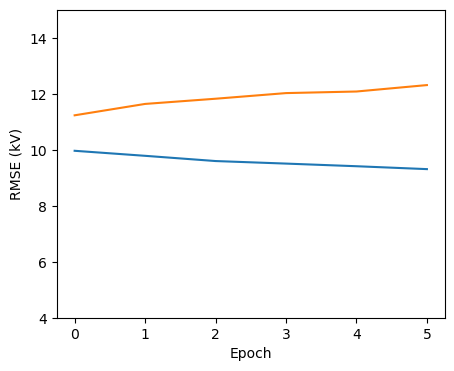

In [26]:
# Plot the RMSE values
plt.figure(figsize=(5, 4))
plt.plot(np.array(np.sqrt(train_losses)), label='RMSE')
plt.plot(np.array(np.sqrt(val_losses)), label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE (kV)')
plt.ylim(4, 15)

In [27]:
#test
model.eval()

test_loss = 0.0
predictions = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        batch_X = batch_X.permute(0, 2, 1)

        output = model(batch_X)
        loss = criterion(output, batch_y)
        test_loss += loss.item()
        predictions.append(output)

predictions = torch.cat(predictions)
predictions = predictions.cpu().numpy()

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {np.sqrt(avg_test_loss):.3f} [kV]')

Test Loss: 8.455 [kV]


In [28]:
pred_ds = X_test_unscaled_ds.isel(dt=slice(lookback, None))
pred_ds['pred_pot'] = (['dt', 'lat', 'lon'], predictions.reshape(-1, 30, 80))

#pred_ds = pred_ds[['potential', 'pred_pot']]
pred_ds['err_abs'] = np.abs(pred_ds['pred_pot'] - pred_ds['potential'])
pred_ds['err_rel'] = (pred_ds['pred_pot'] - pred_ds['potential']) / pred_ds['potential']
pred_ds['MLT'] = np.mod(pred_ds['lon'] / 15, 24)

pred_ds

<xarray.Dataset> Size: 166MB
Dimensions:         (dt: 4317, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 35kB 2022-07-01T00:15:00 ... 2022-07-...
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 1.6 6.106 10.61 ... 348.6 353.1 357.6
Data variables:
    potential       (dt, lat, lon) float32 41MB 9.783 8.498 ... -6.339 -6.347
    BY_GSE          (dt) float64 35kB -1.6 -1.61 -1.68 -1.77 ... 6.04 6.08 6.79
    BZ_GSE          (dt) float64 35kB -0.36 -0.3 -0.41 ... -2.75 -2.64 -1.09
    tilt_angle      (dt) float64 35kB 0.3431 0.3398 0.3367 ... 0.3315 0.3281
    flow_speed      (dt) float64 35kB 346.0 345.0 346.0 ... 523.0 519.0 487.0
    proton_density  (dt) float64 35kB 4.35 4.32 4.24 4.32 ... 0.33 0.34 0.34 0.3
    pred_pot        (dt, lat, lon) float32 41MB 1.157 0.7352 ... 11.8 11.79
    err_abs         (dt, lat, lon) float32 41MB 8.626 7.763 ... 18.14 18.14
    err_rel         (dt, lat, lon) float32 41MB -0.8817 -0.9135 ... -2.858
    MLT             (lon) float64 640B 0.1067 0.4071 0.7075 ... 23.54 23.84

In [29]:
def nan_count(ds, var):
    #count number of NaNs in a data variable
    con_data = ds[var].values
    nan_count = np.count_nonzero(np.isnan(con_data))
    nan_ratio = nan_count / con_data.size
    not_nan = con_data.size - nan_count
    return not_nan, np.round(nan_ratio, 2)

nan_count(pred_ds, 'err_rel')

(10360800, 0.0)

In [30]:
potential = pred_ds['potential'].values
potential = potential.reshape(-1, 30, 80)

pred_pot = pred_ds['pred_pot'].values
pred_pot = pred_pot.reshape(-1, 30, 80)

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / 
            np.sum((o - np.mean(o))**2))

    return skill             

RMSE = np.sqrt(np.mean((potential - pred_pot)**2))
MAE = np.mean(np.abs(potential - pred_pot))
PE = skill(potential, pred_pot)
R = np.corrcoef(potential.flatten(), pred_pot.flatten())[0, 1]

print(f'RMSE: {RMSE:.2f} kV')
print(f'MAE: {MAE:.1f} kV')
print(f'R: {R:.2f}/1')
#print(f'PE: {PE:.2f}/1')

RMSE: 8.45 kV
MAE: 5.7 kV
R: 0.58/1


/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


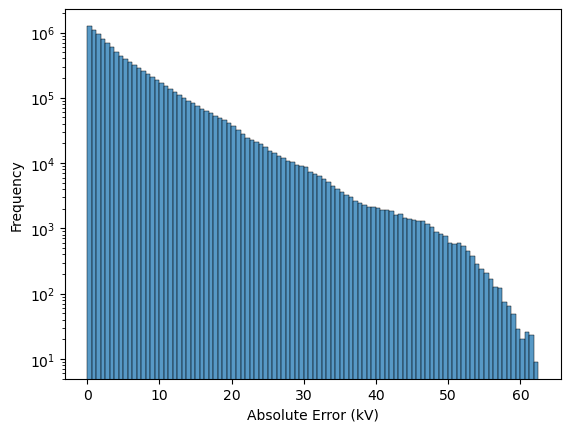

In [31]:
#plot hist of AE
sns.histplot(pred_ds['err_abs'].values.flatten(), bins=100)
plt.xlabel('Absolute Error (kV)')
plt.ylabel('Frequency')
plt.yscale('log')

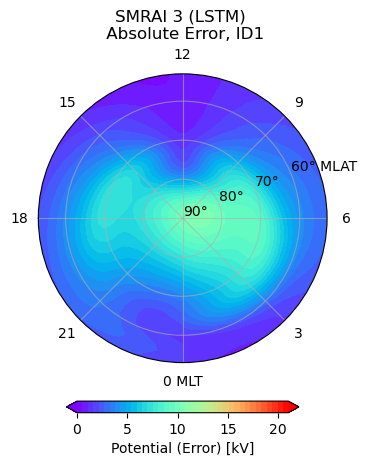

In [32]:
# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .5

# Plot true values
abs_error = (pred_ds['err_abs'].mean('dt').values)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6,5))

c_true = ax.contourf(theta_rad, r, abs_error, levels=np.linspace(0, 21, 40), cmap='rainbow', extend='both')
ax.set_ylim([0, 37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
ax.set_title(f'SMRAI 3 (LSTM) \n Absolute Error, ID1')
plt.colorbar(c_true, ax=ax, label='Potential (Error) [kV]', shrink=shrink, pad=0.1, ticks=np.arange(0,21,5), orientation='horizontal')
ax.grid(True, linestyle='-', alpha=0.6)
#plt.tight_layout()
#plt.savefig('smrai_lstm_ID1.png', dpi=400, bbox_inches='tight')

In [33]:
abs_error.shape

(30, 80)